In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from scipy.spatial.distance import euclidean, cityblock

from PIL import Image
from rdm import *

In [2]:
f_cond=[
    ('F01','Joy','unshuffled'),
    ('F01','Joy','shuffled'),
    ('F03','Joy','unshuffled'),
    ('F03','Joy','shuffled'),
    ('F02','Sadness','unshuffled'),
    ('F02','Sadness','shuffled'),
    ('F04','Sadness','unshuffled'),
    ('F04','Sadness','shuffled'),
    ('F06','MouthOpening','unshuffled'),
    ('F06','MouthOpening','shuffled'),
    ('F07','MouthOpening','unshuffled'),
    ('F07','MouthOpening','shuffled')
]
f_label=[]
for (actor,movement,status) in f_cond:
    f_label.append('{} {} {}'.format(actor,movement,status))

In [3]:
out_base_path='/home/bonaiuto/infant_face_eeg/derivatives/9m'
stim_path='/home/common/bonaiuto/infant_face_eeg/stimuli/9month'
n_pixels=1244160
#n_flow=576
n_gabor=414720


def generate_pixel_rdm(f_cond):
    image_vectors = np.zeros((len(f_cond), n_pixels))

    # Loop over conditions
    rdm=np.ones((len(f_cond),len(f_cond)))
    for i, cond1 in enumerate(f_cond):
        for j, cond2 in enumerate(f_cond):
            if cond1[0]==cond2[0]:
                rdm[i,j]=0
                rdm[j,i]=0
    for f_idx, (actor, movement, status) in enumerate(f_cond):
        print(f'{actor} {movement} {status}')
        frame_fname=os.path.join(stim_path, f'{actor}-{movement}-Face Forward.no_static.png')
        if status == 'shuffled':
            frame_fname=os.path.join(stim_path, f'{actor}-{movement}-Face Forward.shuffled.no_static.png')

        img_vector=process_frame_pixel(frame_fname, n_pixels)        

        image_vectors[f_idx,:]=img_vector
    
    rdm=compute_frame_pixel_rdm(image_vectors)
    return rdm


def generate_contrast_rdm(f_cond):
    image_contrasts = np.zeros((len(f_cond), 1))

    # Loop over conditions
    for f_idx, (actor, movement, status) in enumerate(f_cond):
        print(f'{actor} {movement} {status}')
        frame_fname=os.path.join(stim_path, f'{actor}-{movement}-Face Forward.no_static.png')
        if status == 'shuffled':
            frame_fname=os.path.join(stim_path, f'{actor}-{movement}-Face Forward.shuffled.no_static.png')

        contrast = process_frame_contrast(frame_fname)        
        
        image_contrasts[f_idx,:]=contrast

    rdm = compute_frame_contrast_rdm(image_contrasts)
    return rdm



def generate_gabor_rdm(f_cond):
    orientations = 6  # Different orientations
    scales = 6
    thetas = np.linspace(0, np.pi, orientations, endpoint=False)
    
    gabor_vectors = np.zeros((len(f_cond), orientations*scales*n_gabor))
    
    # Loop over conditions
    for f_idx, (actor, movement, status) in enumerate(f_cond):
        print(f'{actor} {movement} {status}')
        frame_fname=os.path.join(stim_path, f'{actor}-{movement}-Face Forward.no_static.png')
        if status == 'shuffled':
            frame_fname=os.path.join(stim_path, f'{actor}-{movement}-Face Forward.shuffled.no_static.png')

        gabor_responses = process_frame_gabor(frame_fname, orientations, scales, n_gabor)
        
        gabor_vectors[f_idx,:]=gabor_responses

    rdm = compute_frame_gabor_rdm(gabor_vectors)    
    
    return rdm

def generate_landmark_rdm(f_cond):
    landmark_vectors=[]
    of_path=os.path.join(stim_path, 'converted_videos/processed')
    for (actor,movement,status) in f_cond:
        fname = os.path.join(of_path, f'{actor}-{movement}-Face Forward.no_static.csv')    
        if status=='shuffled':
            fname = os.path.join(of_path, f'{actor}-{movement}-Face Forward.shuffled.no_static.csv')
    
        df=pd.read_csv(fname)
        
        # Selecting the X_0 to X_67, Y_0 to Y_67, and Z_0 to Z_67 columns and converting them to a numpy array
        selected_columns = ['X_{}'.format(i) for i in range(16,68)] + \
                        ['Y_{}'.format(i) for i in range(16,68)] + \
                        ['Z_{}'.format(i) for i in range(16,68)]
        
        # Get the values as a numpy array
        values_array = df[selected_columns].values
        
        # Get first row
        vector = values_array[0,:]
        landmark_vectors.append(vector)
            
    landmark_vectors=np.array(landmark_vectors)
    
    # Calculating the RDM matrix    
    rdm = np.zeros((len(f_cond), len(f_cond)))
    
    # Compute the Euclidean distances and populate the distance matrix
    for i in range(len(f_cond)):
        for j in range(i+1,len(f_cond)):
            distances = [
                euclidean(landmark_vectors[i][k*3:k*3+3], landmark_vectors[j][k*3:k*3+3]) for k in range(int(landmark_vectors.shape[-1]/3))
            ]
            # Take the average of the distances for X, Y, and Z coordinates
            avg_distance = np.mean(distances)
            rdm[i, j] = avg_distance
            rdm[j, i] = avg_distance
    rdm=np.array(rdm)
    return rdm


def generate_au_r_rdm(f_cond):
    au_r_vectors=[]
    of_path=os.path.join(stim_path, 'converted_videos/processed')
    for (actor,movement,status) in f_cond:
        fname = os.path.join(of_path, f'{actor}-{movement}-Face Forward.no_static.csv')    
        if status=='shuffled':
            fname = os.path.join(of_path, f'{actor}-{movement}-Face Forward.shuffled.no_static.csv')

        df=pd.read_csv(fname)
        
        selected_columns = [
         'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 
         'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r'
        ]
        
        # Get the values as a numpy array
        values_array = df[selected_columns].values
    
        # Since the DataFrame has one row, select the first row to get a vector
        vector = values_array[0,:]
        au_r_vectors.append(vector)
    
    au_r_vectors=np.array(au_r_vectors)

    au_r_vectors+=.001*np.random.randn(au_r_vectors.shape[0], au_r_vectors.shape[1])
    
    au_r_corr, _ = spearmanr(au_r_vectors.T)
    au_r_corr = 0.5 * (au_r_corr + au_r_corr.T)  # Making the matrix symmetric
        
    # Calculating the RDM matrix
    rdm = 1-au_r_corr
    np.fill_diagonal(rdm, 0)  # Setting the diagonal to zero
    rdm=np.array(rdm)
    return rdm

def generate_au_c_rdm(f_cond):
    au_c_vectors=[]
    of_path=os.path.join(stim_path, 'converted_videos/processed')
    for (actor,movement,status) in f_cond:
        fname = os.path.join(of_path, f'{actor}-{movement}-Face Forward.no_static.csv')    
        if status=='shuffled':
            fname = os.path.join(of_path, f'{actor}-{movement}-Face Forward.shuffled.no_static.csv')
    
        df=pd.read_csv(fname)
        
        selected_columns = [
         'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 'AU10_c', 
         'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c'
        ]
        
        # Get the values as a numpy array
        values_array = df[selected_columns].values
    
        # Since the DataFrame has one row, select the first row to get a vector
        vector = values_array[0,:]
        au_c_vectors.append(vector)
        
    au_c_vectors=np.array(au_c_vectors)

    # Calculate the Manhattan distances between binary vectors
    rdm = np.zeros((len(f_cond), len(f_cond)))
    
    for i in range(len(f_cond)):
        for j in range(i + 1, len(f_cond)):
            distance = cityblock(au_c_vectors[i,:], au_c_vectors[j,:])
            rdm[i, j] = distance
            rdm[j, i] = distance  # RDM matrix is symmetric
    
    # Set the diagonal to zero
    np.fill_diagonal(rdm, 0)
    return rdm

In [4]:
actor_rdm=generate_actor_rdm(f_cond)

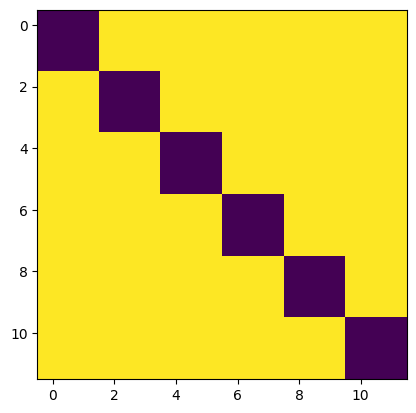

In [5]:
plt.imshow(actor_rdm)

In [6]:
movement_type_rdm=generate_movement_type_rdm(f_cond)

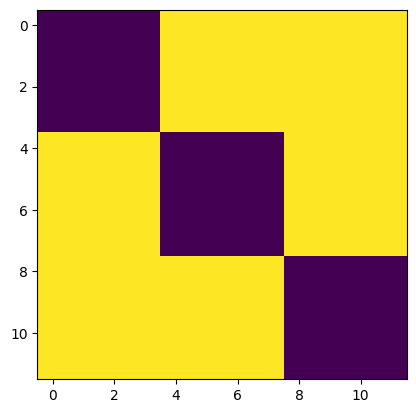

In [7]:
plt.imshow(movement_type_rdm)

In [8]:
shuffled_rdm=generate_shuffled_rdm(f_cond)

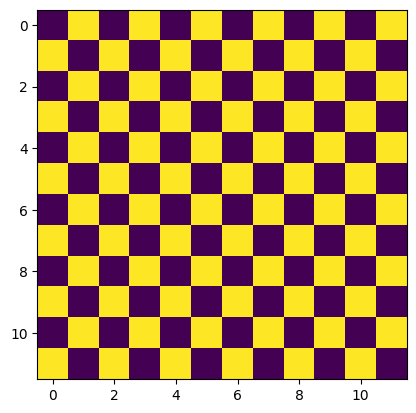

In [9]:
plt.imshow(shuffled_rdm)

In [10]:
pixel_rdm=generate_pixel_rdm(f_cond)

F01 Joy unshuffled
F01 Joy shuffled
F03 Joy unshuffled
F03 Joy shuffled
F02 Sadness unshuffled
F02 Sadness shuffled
F04 Sadness unshuffled
F04 Sadness shuffled
F06 MouthOpening unshuffled
F06 MouthOpening shuffled
F07 MouthOpening unshuffled
F07 MouthOpening shuffled


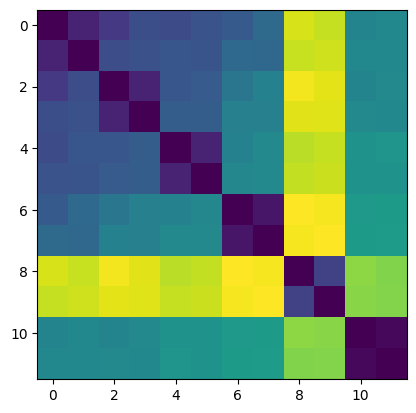

In [11]:
plt.imshow(pixel_rdm)

In [12]:
contrast_rdm=generate_contrast_rdm(f_cond)

F01 Joy unshuffled
F01 Joy shuffled
F03 Joy unshuffled
F03 Joy shuffled
F02 Sadness unshuffled
F02 Sadness shuffled
F04 Sadness unshuffled
F04 Sadness shuffled
F06 MouthOpening unshuffled
F06 MouthOpening shuffled
F07 MouthOpening unshuffled
F07 MouthOpening shuffled


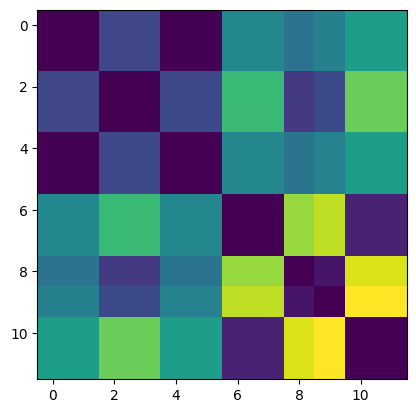

In [13]:
plt.imshow(contrast_rdm)

In [14]:
gabor_rdm=generate_gabor_rdm(f_cond)

F01 Joy unshuffled
F01 Joy shuffled
F03 Joy unshuffled
F03 Joy shuffled
F02 Sadness unshuffled
F02 Sadness shuffled
F04 Sadness unshuffled
F04 Sadness shuffled
F06 MouthOpening unshuffled
F06 MouthOpening shuffled
F07 MouthOpening unshuffled
F07 MouthOpening shuffled


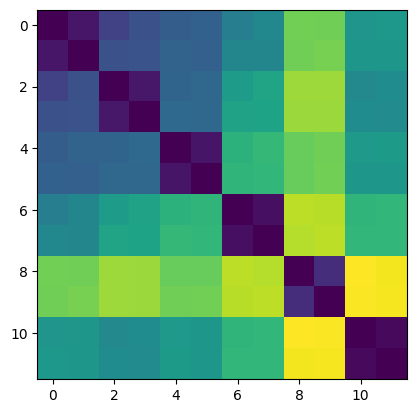

In [15]:
plt.imshow(gabor_rdm)

In [16]:
landmark_rdm=generate_landmark_rdm(f_cond)

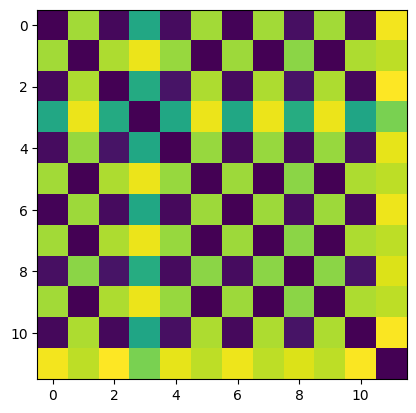

In [17]:
plt.imshow(landmark_rdm)

In [18]:
au_r_rdm=generate_au_r_rdm(f_cond)

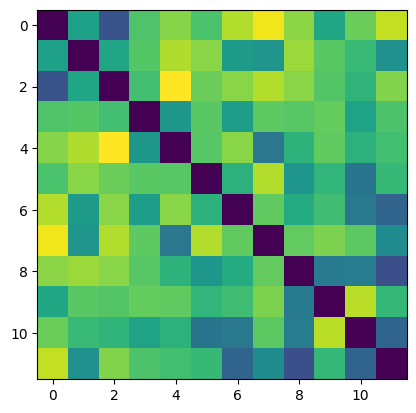

In [19]:
plt.imshow(au_r_rdm)

In [20]:
au_c_rdm=generate_au_c_rdm(f_cond)

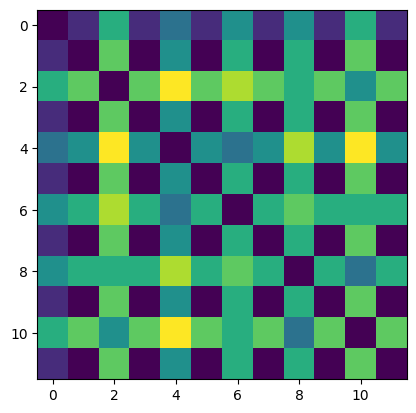

In [21]:
plt.imshow(au_c_rdm)

In [22]:
model_rdms={
    'actor': actor_rdm,
    'movement_type': movement_type_rdm,
    'shuffled': shuffled_rdm,
    'pixel': pixel_rdm,
    'contrast': contrast_rdm,
    'gabor': gabor_rdm,
    'landmark': landmark_rdm,
    'au_r': au_r_rdm,
    'au_c': au_c_rdm
}
np.savez(
    os.path.join(out_base_path, 'model_static_rdms.npz'),
    model_rdms=model_rdms
)

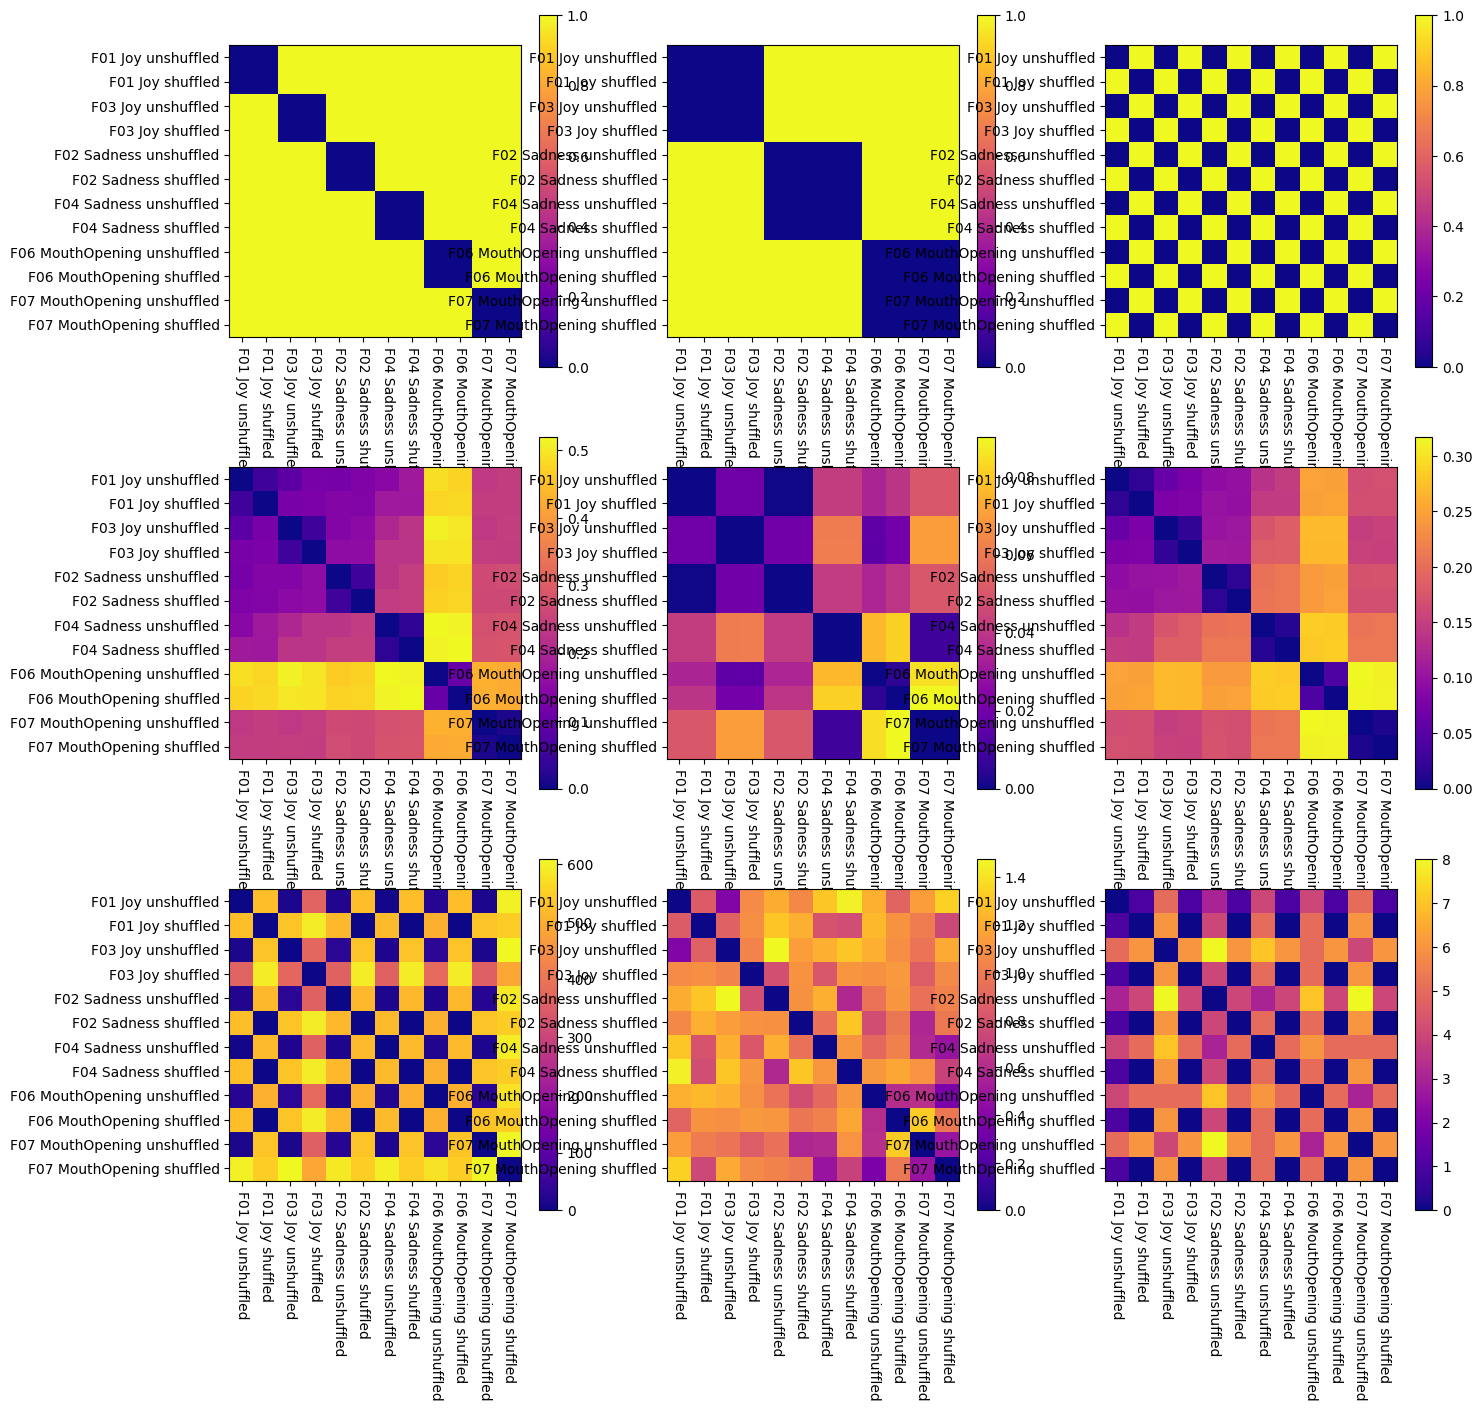

In [23]:
plt.figure(figsize=(16,21))

ax=plt.subplot(4,3,1)
im=ax.imshow(actor_rdm, cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)

ax=plt.subplot(4,3,2)
im=ax.imshow(movement_type_rdm, cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)

ax=plt.subplot(4,3,3)
im=ax.imshow(shuffled_rdm, cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)

ax=plt.subplot(4,3,4)
im=ax.imshow(pixel_rdm, cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)

ax=plt.subplot(4,3,5)
im=ax.imshow(contrast_rdm, cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)

ax=plt.subplot(4,3,6)
im=ax.imshow(gabor_rdm, cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)

ax=plt.subplot(4,3,7)
im=ax.imshow(landmark_rdm, cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)

ax=plt.subplot(4,3,8)
im=ax.imshow(au_r_rdm, cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)

ax=plt.subplot(4,3,9)
im=ax.imshow(au_c_rdm, cmap='plasma')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticks(np.arange(len(f_cond)))
ax.set_xticklabels(f_label, rotation=-90)
ax.set_yticks(np.arange(len(f_cond)))
ax.set_yticklabels(f_label)
plt.colorbar(im)
# plt.savefig('../output/RMDs.svg')